In [1]:
# Reload local modules if they've changed.
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import sys
import os
from sklearn.preprocessing import LabelEncoder
import datetime

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.data.read_parallel import read_parallel_local


import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_"+metric], "")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

In [3]:
import transformers
print (sys.version)
print(transformers.__version__)
print(tf.__version__)

3.8.5 (default, Jul 28 2020, 12:59:40) 
[GCC 9.3.0]
4.3.3
2.4.1


In [5]:
from src.models.deeplegis import legislationDataset, legislationDatasetText, legislationDatasetRevCat, legislationDatasetAll, legislationDatasetNoText
from src.models.deeplegis import deep_legis_text, deep_legis_pl, deep_legis_all, deep_legis_vn_cat, deep_legis_no_text

In [9]:
REDUCE_BY_FACTOR = 1000 # Make the dataset smaller for development purposes
train_test_ratio = 0.91
train_valid_ratio = 0.90

if 'DATA_VOL' not in os.environ:
    # Manually set:
    DATA_VOL = '/home/luke/tmp_vol/'
else:
    DATA_VOL = os.environ['DATA_VOL']
    
# Pre-wrangled metadata
df = pd.read_csv("../references/derived/ml_data.csv", encoding="latin1", parse_dates=True)
df.id = df.id.astype(int)    
print(f"Original number of examples: {len(df)}")
df = df.sample(n=int(len(df)/REDUCE_BY_FACTOR)) #
print(f"Reduced number of examples:  {len(df)}")

tmp = read_parallel_local(df['id'], DATA_VOL + "/clean/")
df['text'] = tmp

df = df.reset_index(drop=True)
sc_id_encoder = LabelEncoder()
df['sc_id_cat'] = sc_id_encoder.fit_transform(df['sc_id'])

Original number of examples: 199451
Reduced number of examples:  199
Took 0.023846129576365154 min to open 199 files with 20 processes.


In [10]:
df.head()

,bill_id,version_number,id,partisan_lean,sc_id,signed,text,sc_id_cat
0,1193779,2,2292457,0.538639,587-2,0,i 116th congress 1st session to support secu...,31
1,1314933,1,2562434,0.754649,580-1,0,x back button image: click to go to previous ...,25
2,1246583,3,2526009,0.393845,622-2,0,committee/subcommittee amendment bill no. hb ...,63
3,1265607,1,2480457,0.525000,626-2,0,2020 session | | | print version 20100994d hou...,69
4,1173121,5,2724857,0.628972,605-1,1,101st general assembly state of illinois and s...,49


In [7]:
config = {}
config['max_length'] = 128
config['train_batch_size'] = 4
config['testing'] = False
config['train_test_ratio'] = 0.91
config['train_valid_ratio'] = 0.90
config['n_sc_id_classes'] = len(sc_id_encoder.classes_)
epochs = 2
legis_builder = legislationDataset(config)
train_stream, val_stream, test_stream = legis_builder.create_batch_stream(df)

Training size: (1634, 8)
Validation size: (182, 8)
Test size: (180, 8)


In [32]:
from src.models.deeplegis import deep_legis_pl 
dl_pl = deep_legis_pl(config)
dl_pl.summary()
dl_pl.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy()])

Some layers from the model checkpoint at allenai/longformer-base-4096 were not used when initializing TFLongformerForSequenceClassification: ['lm_head']
- This IS expected if you are initializing TFLongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFLongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFLongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
longformer (TFLongformerMainLay TFLongformerBaseMode 148068864   input_ids[0][0]                  
__________________________________________________________________________________________________
tf.__operators__.getitem_2 (Sli (None, 768)          0           longformer[0][0]                 
__________________________________________________________________________________________________
dropout_154 (Dropout)           (None, 768)          0           tf.__operators__.getitem_2[0][0] 
____________________________________________________________________________________________

Epoch 1/2
40/40 [==============================] - 196s 3s/step - loss: 0.7796 - binary_accuracy: 0.4058 - val_loss: 0.4926 - val_binary_accuracy: 0.8125
Epoch 2/2
40/40 [==============================] - 97s 2s/step - loss: 0.4760 - binary_accuracy: 0.8514 - val_loss: 0.4780 - val_binary_accuracy: 0.8125


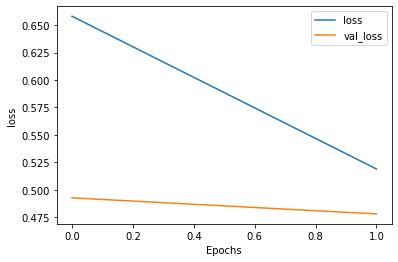

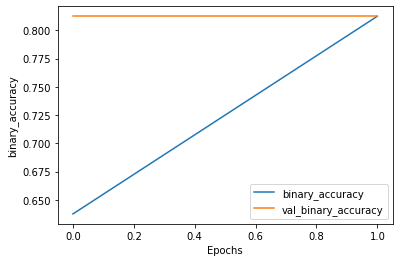

In [33]:

log_dir = "../logs/fit/dl_pl_"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch='10, 15')

history = dl_pl.fit(train_stream,
                   validation_data=val_stream,
                   epochs=epochs,
                    callbacks=[tensorboard_callback],
                   verbose=1)
plot_graphs(history, 'loss')
plot_graphs(history, 'binary_accuracy')

In [9]:
#from numba import cuda
#cuda.select_device(0)
#cuda.close()
config = {}
config['max_length'] = 128
config['train_batch_size'] = 4
config['testing'] = False
config['train_test_ratio'] = 0.91
config['train_valid_ratio'] = 0.90
config['n_sc_id_classes'] = len(sc_id_encoder.classes_)
epochs = 2
from src.models.deeplegis import legislationDatasetText
from src.models.deeplegis import deep_legis_text

legis_builder = legislationDatasetText(config)
train_stream, val_stream, test_stream = legis_builder.create_batch_stream(df)
dl_text = deep_legis_text(config)
dl_text.summary()
dl_text.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy()])
log_dir = "../logs/fit/dl_text_"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch='10, 15')

history = dl_text.fit(train_stream,
                   validation_data=val_stream,
                   epochs=epochs,
                    callbacks=[tensorboard_callback],
                   verbose=1)

plot_graphs(history, 'loss')
plot_graphs(history, 'binary_accuracy')

[autoreload of src.models.deeplegis failed: Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/ubuntu/anaconda3/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/ubuntu/anaconda3/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<frozen importlib._bootstrap_external>", line 791, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/ubuntu/g

Training size: (1634, 8)
Validation size: (182, 8)
Test size: (180, 8)


Some layers from the model checkpoint at allenai/longformer-base-4096 were not used when initializing TFLongformerForSequenceClassification: ['lm_head']
- This IS expected if you are initializing TFLongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFLongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFLongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


KeyboardInterrupt: 

In [17]:
# All metadata
config = {}
config['max_length'] = 128
config['train_batch_size'] = 4
config['testing'] = False
config['train_test_ratio'] = 0.91
config['train_valid_ratio'] = 0.90
config['n_sc_id_classes'] = len(sc_id_encoder.classes_)
epochs = 5
print(config)
from src.models.deeplegis import legislationDatasetAll
from src.models.deeplegis import deep_legis_all

legis_builder = legislationDatasetAll(config)
train_stream, val_stream, test_stream = legis_builder.create_batch_stream(df)
dl_all = deep_legis_all(config)
dl_all.summary()
dl_all.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy()])
log_dir = "../logs/fit/dl_all_"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch='10, 15')

history = dl_all.fit(train_stream,
                   validation_data=val_stream,
                   epochs=epochs,
                    callbacks=[tensorboard_callback],
                   verbose=1)

plot_graphs(history, 'loss')
plot_graphs(history, 'binary_accuracy')

{'max_length': 128, 'train_batch_size': 4, 'testing': False, 'train_test_ratio': 0.91, 'train_valid_ratio': 0.9, 'n_sc_id_classes': 125}
Training size: (1634, 8)
Validation size: (182, 8)
Test size: (180, 8)


Some layers from the model checkpoint at allenai/longformer-base-4096 were not used when initializing TFLongformerForSequenceClassification: ['lm_head']
- This IS expected if you are initializing TFLongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFLongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFLongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(None, 125)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
longformer (TFLongformerMainLay TFLongformerBaseMode 148068864   input_ids[0][0]                  
__________________________________________________________________________________________________
tf.__operators__.getitem_5 (Sli (None, 768)          0           longformer[0][0]                 
__________________________________________________________________________________________________
dropout_507 (Dropout)           (None, 768)          0           tf.__operators__.getitem_5[0][0] 
________________________________________________________________________________

InvalidArgumentError:  ConcatOp : Ranks of all input tensors should match: shape[0] = [4,768] vs. shape[3] = [4,1,125]
	 [[node model_2/tf.concat_4/concat (defined at <ipython-input-17-792b83d2b9f6>:28) ]] [Op:__inference_train_function_564860]

Function call stack:
train_function


In [14]:
len(sc_id_encoder.classes_)

122

In [68]:
config = {}
config['max_length'] = 128
config['train_batch_size'] = 4
config['testing'] = False
config['train_test_ratio'] = 0.91
config['train_valid_ratio'] = 0.90
config['n_sc_id_classes'] = len(sc_id_encoder.classes_)
print(config)
from src.models.deeplegis import legislationDatasetRevCat
legis_builder = legislationDatasetRevCat(config)
train_stream, val_stream, test_stream = legis_builder.create_batch_stream(df)
from src.models.deeplegis import deep_legis_vn_cat
dl_vn_cat = deep_legis_vn_cat(config)
dl_vn_cat.summary()
dl_vn_cat.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy()])
log_dir = "../logs/fit/dl_vn_cat_"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch='10, 15')

history = dl_vn_cat.fit(train_stream,
                   validation_data=val_stream,
                   epochs=epochs,
                    callbacks=[tensorboard_callback],
                   verbose=1)

plot_graphs(history, 'loss')
plot_graphs(history, 'binary_accuracy')

{'max_length': 128, 'train_batch_size': 32, 'testing': False, 'train_test_ratio': 0.91, 'train_valid_ratio': 0.9, 'n_sc_id_classes': 70}
Training size: (162, 8)
Validation size: (19, 8)
Test size: (18, 8)
({'input_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
array([[    0,  1437,  1437, ..., 38187,   102,     2],
       [    0,  5615,   937, ...,  4484,     9,     2],
       [    0,   627, 22437, ...,   899,     7,     2],
       ...,
       [    0,  7305,   877, ...,  4458,     6,     2],
       [    0,   194,     9, ...,     6,   109,     2],
       [    0,  2914,  1707, ...,    12, 10224,     2]], dtype=int32)>, 'version_number': <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([1., 2., 1., 2., 2., 1., 1., 2., 1., 1., 5., 1., 2., 1., 3., 2., 2.,
       1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 4., 1., 2., 1.],
      dtype=float32)>, 'sc_ids': <tf.Tensor: shape=(32, 1, 70), dtype=int32, numpy=
array([[[0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0]],

     

{'max_length': 128, 'train_batch_size': 4, 'testing': False, 'train_test_ratio': 0.91, 'train_valid_ratio': 0.9, 'n_sc_id_classes': 84}
Training size: (162, 8)
Validation size: (19, 8)
Test size: (18, 8)
(None, 84)
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
partisan_lean (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
version_number (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
sc_id (InputLayer)              [(None, 84)]         0                                            
___________________________________________________________________________

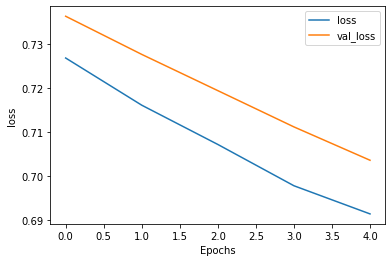

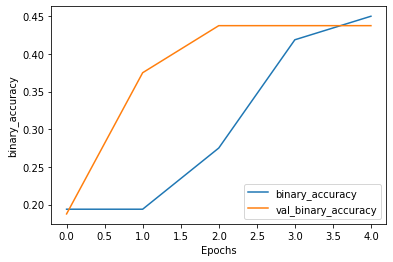

In [29]:
# No text at all, reference model
epochs = 5
config = {}
config['max_length'] = 128
config['train_batch_size'] = 4
config['testing'] = False
config['train_test_ratio'] = 0.91
config['train_valid_ratio'] = 0.90
config['n_sc_id_classes'] = len(sc_id_encoder.classes_)
print(config)
from src.models.deeplegis import legislationDatasetNoText
legis_builder = legislationDatasetNoText(config)
train_stream, val_stream, test_stream = legis_builder.create_batch_stream(df)

from src.models.deeplegis import deep_legis_no_text
dl_no_text = deep_legis_no_text(config)
dl_no_text.summary()
dl_no_text.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy()])

log_dir = "../logs/fit/dl_no_text_"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch='10, 15')

history = dl_no_text.fit(train_stream,
                   validation_data=val_stream,
                   epochs=epochs,
                    callbacks=[tensorboard_callback],
                   verbose=1)

plot_graphs(history, 'loss')
plot_graphs(history, 'binary_accuracy')

In [21]:
len(sc_id_encoder.classes_)

84

In [27]:
for elem in train_stream.take(1):
    print(elem)

({'partisan_lean': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.7085218 , 0.5386392 , 0.23762377, 0.375     ], dtype=float32)>, 'version_number': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([2., 1., 1., 5.], dtype=float32)>, 'sc_id': <tf.Tensor: shape=(4, 1, 125), dtype=int32, numpy=
array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [31]:
tf.squeeze(tf.one_hot([1], 5, dtype='float32'),0)

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 0., 0., 0.], dtype=float32)>

In [35]:
tf.reshape(tf.one_hot([1], 5, dtype='float32'), (5,))

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 0., 0., 0.], dtype=float32)>